In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_yaml
from skimage.feature import canny
import matplotlib.pyplot as plt
import sys
import os
import cv2

RUN_ID = "1"
check = "test"

def load_images(dirname):
    imlist =[]
    for fname in os.listdir(dirname):
        im = np.array(cv2.imread(dirname+fname))
        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#         im_filter = canny(im_gray)
#         im_filter = np.array(im_filter, dtype=np.uint8)
#         M = cv2.moments(im_filter)
#         center_x = int(M['m10']/M['m00'])
#         center_y = int(M['m01']/M['m00'])
#         size_y = 400
#         im = im_gray[int(center_y - size_y/2) : int(center_y + size_y/2), 500:-200]
        im_gray = im_gray[10:-10, 90:-90]
        im = im_gray
        im = (im - np.average(im))/np.std(im)
        im_canny = np.resize(canny(im), (im.shape[0], im.shape[1], 1))
        im = np.resize(im, (im.shape[0], im.shape[1], 1))
        im = np.concatenate((im, im_canny), axis=2)
        imlist.append(im)

    imlist = np.array(imlist)
    return imlist



Using TensorFlow backend.


53/53 [==============================] - 4s 71ms/step
Samples = 53
Accuracy = 0.981
Incorrect = 1


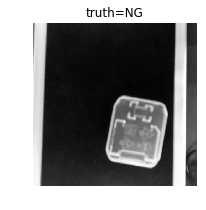

In [2]:
if check == "valid":
    x_test = np.load("npy/x_validdetect_400-900.npy")
    y_test = np.load("npy/y_validdetect_400-900.npy")

    model = model_from_yaml(open("model/" + RUN_ID + ".yaml").read())
    model.load_weights( "model/" + RUN_ID + "_weight.h5")

    #OK:0,NG:1
    y_pred = np.round(model.predict(x_test, batch_size = 48, verbose=1))
    y_pred = y_pred.flatten()
    correct = (y_pred == y_test)

    print('Samples = %d'%len(y_test))
    print('Accuracy = %.3f'%np.mean(correct))
    print('Incorrect = %d'%np.sum(~correct))

    #make error image
    x_pred_error = x_test[y_pred != y_test]
    y_pred_error = y_test[y_pred != y_test]
    names = ["OK","NG"]
    for i in range(x_pred_error.shape[0]):
        im = x_pred_error[i, :, :, 0]
        fig = plt.figure(figsize=(8,3))
        plt.imshow(im, cmap="gray")
        plt.title("truth={}".format(names[y_pred_error[i]]))
        plt.axis("off")
        fig.savefig("data/predict_error_case/"+str(i)+".jpg")


if check == "test":
    imlist_ok_test = load_images("data/sd_ok/")
    imlist_ng_test = load_images("data/sd_ng/")

    x_test = np.concatenate( [imlist_ok_test[-int(imlist_ok_test.shape[0]*0.2):],
                         imlist_ng_test], axis=0)
    y_test = np.array([0]*int(imlist_ok_test.shape[0]*0.2) + [1]*int(imlist_ng_test.shape[0]))

    model = model_from_yaml(open("model/" + RUN_ID + ".yaml").read())
    model.load_weights( "model/" + RUN_ID + "_weight.h5")

    #OK:0,NG:1を返す
    y_pred = np.round(model.predict(x_test, batch_size = 48, verbose=1))
    y_pred = y_pred.flatten()
    correct = (y_pred == y_test)

    print('Samples = %d'%len(y_test))
    print('Accuracy = %.3f'%np.mean(correct))
    print('Incorrect = %d'%np.sum(~correct))

    #make error image
    x_pred_error = x_test[y_pred != y_test]
    y_pred_error = y_test[y_pred != y_test]
#     !を取り除くとコレクトの値を持ってくる
    names = ["OK","NG"]
    for i in range(x_pred_error.shape[0]):
        im = x_pred_error[i, :, :, 0]
        fig = plt.figure(figsize=(8,3))
        plt.imshow(im, cmap="gray")
        plt.title("truth={}".format(names[y_pred_error[i]]))
        plt.axis("off")
        fig.savefig("data/predict_error_case/"+str(i)+".jpg")
